In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge

import random
import math
import time

import matplotlib.pyplot as plt
from functions import train_test

In [2]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [3]:
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

rating_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [4]:
rating_matrix = np.array(rating_df)

In [5]:
known = []

for u in range(rating_matrix.shape[0]):
    for i in range(rating_matrix.shape[1]):
        if rating_matrix[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [6]:
def get_recommendations(pred, k=5):
    rec_list = []
    
    for u in range(pred.shape[0]):
        rec = np.argpartition(pred[u],-k)[-k:]
        rec_list.append(rec)
    
    return np.array(rec_list)

In [7]:
def get_metrics(test_matrix, user_rec):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for u in range(user_rec.shape[0]):
        for i in user_rec[u]:
            if test_matrix[u][i] == 1:
                true_positive+=1
            else:
                false_positive+=1
                
    for u in range(test_matrix.shape[0]):
        for i in range(test_matrix.shape[1]):
            if test_matrix[u][i] == 1 and i not in user_rec[u]:
                false_negative+=1
    
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score

In [8]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

for u, i in testing:
    test_matrix[u][i] = 1

In [9]:
def LREC(dataset, inv_reg=0.01, user_list=None):
    
    if user_list == None:
        user_list = range(dataset.shape[0])
        
    X = dataset.T
    Y = X*2 - 1

    W = []

    for index in user_list:
        if 1 in Y.T[index] and -1 in Y.T[index]:
            log_r = LogisticRegression(C=inv_reg).fit(X, Y.T[index])
            W.append(log_r.coef_[0])
        else:
            W.append(np.zeros(dataset.shape[0]))
    
    W = np.array(W)
    pred = np.dot(W.T, dataset[user_list])
    
    train_replace = pred.min() - 1

    for u, i in training:
        pred[u][i] = train_replace
    
    return pred

In [45]:
reg_terms = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005,0.0025, 0.0001]
scores = []

for reg in reg_terms:
    pred = LREC(train_matrix, inv_reg=reg)
    user_rec = get_recommendations(pred, k=15)
    
    print("inverse reg =", reg)
    scores.append(get_metrics(test_matrix, user_rec))
    print()

inverse reg = 0.1
Precision : 0.20579234972677596
Recall : 0.10170132325141777
F1 Score : 0.13612868245075005

inverse reg = 0.075
Precision : 0.21005464480874317
Recall : 0.10380772346745881
F1 Score : 0.13894812940538587

inverse reg = 0.05
Precision : 0.21650273224043715
Recall : 0.10699432892249527
F1 Score : 0.14321344659316826

inverse reg = 0.025
Precision : 0.22546448087431695
Recall : 0.11142317040237645
F1 Score : 0.1491415145490692

inverse reg = 0.01
Precision : 0.22153005464480874
Recall : 0.10947880097218471
F1 Score : 0.14653894812940538

inverse reg = 0.0075
Precision : 0.21934426229508197
Recall : 0.1083985957331893
F1 Score : 0.1450930778962588

inverse reg = 0.005
Precision : 0.20994535519125684
Recall : 0.10375371320550905
F1 Score : 0.13887583589372854

inverse reg = 0.0025
Precision : 0.19934426229508198
Recall : 0.09851471779638131
F1 Score : 0.13186336526296766

inverse reg = 0.0001
Precision : 0.19092896174863389
Recall : 0.09435592762624899
F1 Score : 0.126296

### Graph

In [46]:
precision_list = []
recall_list = []
F1_list = []

for s in scores:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

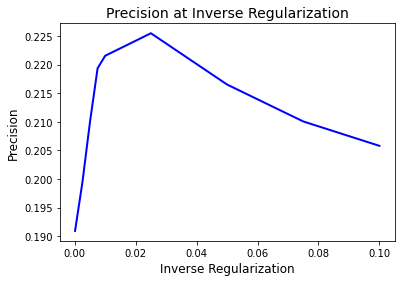

In [53]:
plt.plot(reg_terms, precision_list, color='blue', linewidth=2)

plt.title('Precision at Inverse Regularization', size=14)
plt.xlabel('Inverse Regularization', size=12)
plt.ylabel('Precision', size=12)


plt.show()

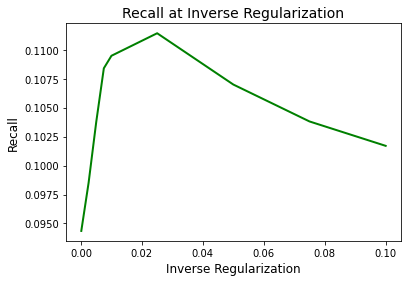

In [48]:
plt.plot(reg_terms, recall_list, color='green', linewidth=2)

plt.title('Recall at Inverse Regularization', size=14)
plt.xlabel('Inverse Regularization', size=12)
plt.ylabel('Recall', size=12)


plt.show()

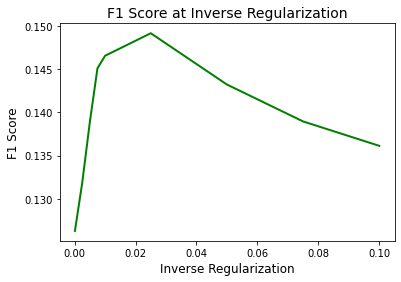

In [52]:
plt.plot(reg_terms, F1_list, color='green', linewidth=2)

plt.title('F1 Score at Inverse Regularization', size=14)
plt.xlabel('Inverse Regularization', size=12)
plt.ylabel('F1 Score', size=12)


plt.show()

# Squared

In [10]:
def LREC_squared(dataset, reg=1.0, user_list=None):
    
    if user_list == None:
        user_list = range(dataset.shape[0])
        
    X = dataset.T
    Y = X*2 - 1

    W = []

    for index in user_list:
     
        
        if 1 in Y.T[index] and -1 in Y.T[index]:
            rdg = Ridge(alpha=reg).fit(X, Y.T[index])
            
            W.append(rdg.coef_)
        else:
            W.append(np.zeros(dataset.shape[0]))
    
        
        
    W = np.array(W)
    
    pred = np.dot(W.T, dataset[user_list])
    
    train_replace = pred.min() - 1

    for u, i in training:
        pred[u][i] = train_replace
    
    return pred

In [95]:
t=time.time()
pred = LREC_squared(train_matrix, reg=50)
user_rec = get_recommendations(pred, k=25)
    
get_metrics(test_matrix, user_rec)
print(time.time()-t)

Precision : 0.19075409836065574
Recall : 0.15711585201188225
F1 Score : 0.17230860358359246
71.15478610992432


In [96]:
reg_terms = [50,100,150,200,250,300,350,400,450,500]
scores_squared = []

for reg_ in reg_terms:
    pred = LREC_squared(train_matrix, reg=reg_)
    user_rec = get_recommendations(pred, k=15)
    
    print("reg term =", reg_)
    scores_squared.append(get_metrics(test_matrix, user_rec))
    print()

reg term = 50
Precision : 0.22360655737704918
Recall : 0.11050499594923036
F1 Score : 0.14791252485089465

reg term = 100
Precision : 0.24120218579234973
Recall : 0.11920064812314339
F1 Score : 0.15955178022772457

reg term = 150
Precision : 0.24830601092896176
Recall : 0.12271131514987847
F1 Score : 0.16425085848545093

reg term = 200
Precision : 0.2492896174863388
Recall : 0.12319740750742642
F1 Score : 0.16490150009036691

reg term = 250
Precision : 0.25016393442622953
Recall : 0.12362948960302457
F1 Score : 0.16547984818362552

reg term = 300
Precision : 0.24885245901639344
Recall : 0.12298136645962733
F1 Score : 0.16461232604373757

reg term = 350
Precision : 0.2484153005464481
Recall : 0.12276532541182825
F1 Score : 0.16432315199710826

reg term = 400
Precision : 0.24950819672131147
Recall : 0.12330542803132595
F1 Score : 0.16504608711368154

reg term = 450
Precision : 0.2476502732240437
Recall : 0.12238725357817985
F1 Score : 0.16381709741550696

reg term = 500
Precision : 0.246

## Graph

In [97]:
precision_list = []
recall_list = []
F1_list = []

for s in scores_squared:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

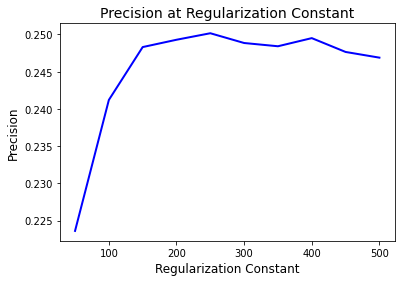

In [104]:
plt.plot(reg_terms, precision_list, color='blue', linewidth=2)

plt.title('Precision at Regularization Constant', size=14)
plt.xlabel('Regularization Constant', size=12)
plt.ylabel('Precision', size=12)


plt.show()

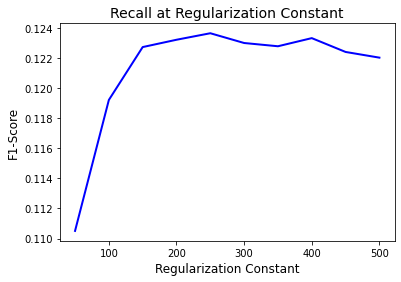

In [103]:
plt.plot(reg_terms, recall_list, color='blue', linewidth=2)

plt.title('Recall at Regularization Constant', size=14)
plt.xlabel('Regularization Constant', size=12)
plt.ylabel('Recall', size=12)


plt.show()

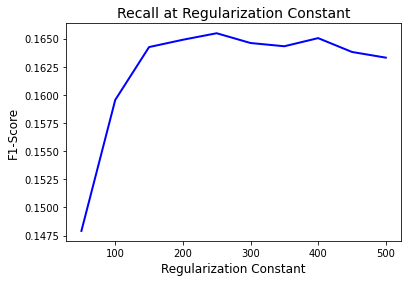

In [106]:
plt.plot(reg_terms, F1_list, color='blue', linewidth=2)

plt.title('Recall at Regularization Constant', size=14)
plt.xlabel('Regularization Constant', size=12)
plt.ylabel('F1-Score', size=12)


plt.show()

## Test 2

In [25]:
def get_metrics2(test_set, recommend_list):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for item in recommend_list:
        if item in test_set:
            true_positive += 1
        else:
            false_positive += 1

    for item in test_set:
        if item not in recommend_list:
            false_negative+=1

    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score


In [11]:
pred = LREC_squared(train_matrix, reg=250)
user_rec = get_recommendations(pred, k=15)

get_metrics(test_matrix, user_rec)


Precision : 0.24415300546448088
Recall : 0.1206589251957872
F1 Score : 0.16150370504247244


(0.24415300546448088, 0.1206589251957872, 0.16150370504247244)

In [15]:
rec_list = []

for u in range(user_rec.shape[0]):
    for i in user_rec[u]:
        rec_list.append((u,i))

In [23]:
rec_list[:15]

[(0, 921),
 (0, 277),
 (0, 2013),
 (0, 474),
 (0, 2194),
 (0, 793),
 (0, 1444),
 (0, 2077),
 (0, 520),
 (0, 1575),
 (0, 1066),
 (0, 97),
 (0, 659),
 (0, 507),
 (0, 901)]

In [18]:
user_rec[0]

array([ 921,  277, 2013,  474, 2194,  793, 1444, 2077,  520, 1575, 1066,
         97,  659,  507,  901])

In [26]:
get_metrics2(testing, rec_list)


Precision : 0.24415300546448088
Recall : 0.1206589251957872
F1 Score : 0.16150370504247244


(0.24415300546448088, 0.1206589251957872, 0.16150370504247244)